### 训练分类器
    前面的章节，介绍了如何定义神经网络，计算loss以及更新weights。
#### 关于数据
    目前，已经有许多开源框架提供了对数据的处理的python包，处理的数据包括image， video， audio和text。
    + images: Pillow和Opencv包
    + audio: Scipy和librosa包
    + text: 直接通过python生成，或者NLTK和Spacy包
    对于vision类，pytorch提供了torchvision包，可以做torchvision.dataset和torch.utils.data.DataLoader，导入imageNet，CIFAR10和Minist等数据集，以及将数据集转换为tensor。
    这些工具大大减轻了开发人员写这些冗余代码的工作。

#### 训练一个图像分类器
    我们将通过下面的步骤，完成图像分类器的训练
    + 通过torchvision包，导入和归一化CIFAR10的训练数据集和测试数据集
    + 定义一个卷积神经网络
    + 定义loss函数
    + 在训练数据集上，训练卷积神经网络
    + 在测试集上，测试卷积神经网络
##### 导入和归一化CIFAR10数据集
    使用torchvision导入CIFAR10数据集，so easy！

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

torchvision的dataset输出是PILImage，取值在[0,1]之间的，通过transforms归一化处理，取值在[-1,-]，

In [6]:
transform = transforms.Compose(
[
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5 ,0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainLoader = torch.utils.data.DataLoader(trainset,batch_size=4,shuffle=True,num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testLoader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


显示训练数据集

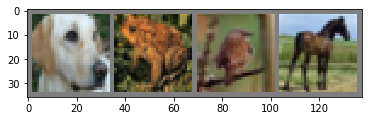

In [8]:
import matplotlib.pyplot as plt
import numpy as np

#显示图片
def imshow(img):
    img = img / 2 + 0.5  #反归一化
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
#获取随机的训练数据
dataiter = iter(trainLoader)
images, labels = dataiter.next()

#显示图片
imshow(torchvision.utils.make_grid(images))

#### 定义卷积神经网络

In [17]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

#### 定义损失函数和优化函数
    使用交叉熵损失函数和动量SGD优化函数

In [18]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum = 0.9)

#### 训练网络
    我们需要将数据传入神经网络处理，计算loss，通过优化函数更新网络参数(weights)，直到达到拟合目标。

In [29]:
num_epochs = 2

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainLoader, 0):
        inputs, labels = data
        
        #将网络梯度设置为0
        optimizer.zero_grad()
        
        #forward + backward + optimizer
        #前向传播 + 后向传播 + 优化参数
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #打印统计信息
        running_loss += loss.item()
        #2000次batch统计一次
        if i % 2000 == 1999:
            print('[%d, %5d] loss = %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
        
print('Finish Training')

[1,  2000] loss = 2.303
[1,  4000] loss = 2.304
[1,  6000] loss = 2.303
[1,  8000] loss = 2.304
[1, 10000] loss = 2.303
[1, 12000] loss = 2.303
[2,  2000] loss = 2.303
[2,  4000] loss = 2.304
[2,  6000] loss = 2.303
[2,  8000] loss = 2.304
[2, 10000] loss = 2.303
[2, 12000] loss = 2.304
Finish Training


#### 保存训练的模型

In [30]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

#### 测试神经网络
    显示测试集的图片

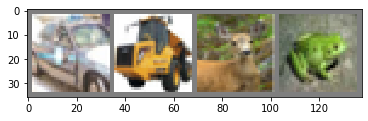

In [31]:
dataiter = iter(testLoader)
images, labels = dataiter.next()

#打印图片
imshow(torchvision.utils.make_grid(images))

重新加载模型

In [32]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

开始验证测试集

In [33]:
outputs = net(images)

outputs的结果返回的是10个类的置信度，置信度最高的类被认为是预测的结果

In [34]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  horse plane horse plane


让我们看看整个神经网络的性能

In [35]:
correct = 0
total = 0

with torch.no_grad():
    for data in testLoader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 11 %


下面的代码统计各个类别的准确率

In [37]:
class_correct = list(0.0 for i in range(10))
class_total = list(0.0 for i in range(10))
with torch.no_grad():
    for data in testLoader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted==labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 49 %
Accuracy of   car :  0 %
Accuracy of  bird :  0 %
Accuracy of   cat :  0 %
Accuracy of  deer :  0 %
Accuracy of   dog :  0 %
Accuracy of  frog :  0 %
Accuracy of horse : 61 %
Accuracy of  ship :  0 %
Accuracy of truck :  0 %


#### GPU上进行训练
    与之前介绍的tensor转移到GPU上类似，torch的神经网络也是通过这种方式进行迁移。
    首先需要定义一个device变量，用来描述设备，如果支持cuda的话，device表示的就是cuda设备，否则为cpu设备

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

下面的方法，会将模型以及模型的参数，buffer都迁移到GPU上

In [ ]:
net.to(device)

另外，我们还需要将模型的输入和输出同时迁移到GPU上

In [ ]:
inputs, labels = data[0].to(device), data[1].to(device)